# What's Cooking: Use recipe ingredients to categorize the cuisine

https://www.kaggle.com/c/whats-cooking

Given a list of ingredients categorize the cuisine. The ingredient lists do not contain amounts of ingredients or any directions in regard to what to do with the ingredients. 

Out initial thoughts on the project were to do a bag of words implementation with the following steps:
1. Turn each ingredient into a single word by replacing spaces with underlines.
2. Combine the list ingredients into a single space separated string.
3. Vectorize the ingredients as string.
4. Test various classification routines against this vectorized data.

We didn't end up too far off from this initial implementation idea but along the way we added some features, changed our vectorization technique and performed a lot of expirements that went no where!

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import json
import csv
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from sklearn.decomposition import PCA
from sklearn.mixture import GMM
from collections import Counter
from collections import defaultdict
import operator

In [2]:
submission_ids, submission_data = [], []
test_data, test_labels = [], []
train_data, train_labels = [], []
mini_train_data, mini_train_labels = [], []
full_train_labels, full_train_data = [], []
target_names, target_labels = [], []

### parse_all_data
This function was created to facilitate experiments. With each experiment we wanted to a fresh set of data, nothing inadvertantly affected by prior experiments. But it needed to be flexible enough that we could change how the data was processed. We include an option parameter to the function that allows the experiment to tweak how the data is loaded. Each experiment essentially begins with its own call to this function.

Eventually we tried to not make single ingedients into a single string with underscores and use N-grams instead. This improved our accuracy.

In [3]:
def parse_all_data(per_recipe_function=None):
    '''Parse all the data and split it into various sets (train, full_train, mini_train and test)'''
    global submission_ids, submission_data, test_data, test_labels, train_data, train_labels
    global mini_train_data, mini_train_labels, full_train_labels, full_train_data, target_names, target_labels
    def parse_data(key_name, raw_data):
        keys, data = [], []
        for recipe in raw_data:
            keys.append(recipe[key_name])
            #ingredient_list = " ".join([x.replace(" ","_") for x in recipe["ingredients"]])
            ingredient_list = " ".join([x for x in recipe["ingredients"]])
            ingredient_list = re.sub(r'[^A-Za-z\s_]', '', ingredient_list)
            #ingredient_list = re.sub(r'_+oz_', '', ingredient_list)
            #ingredient_list = re.sub(r' _+', '', ingredient_list)
            # This adds the word *count* to the list of ingredients equal to the number of ingredients
            # this results in a vectorization that includes a last feature that has a count
            # equal to the number of ingredients.
            ingredient_list += (" *count*" * len(ingredient_list.split(" ")))  

            if per_recipe_function is not None:
                ingredient_list = per_recipe_function(ingredient_list)

            data.append(ingredient_list)
        return keys, data

    with open('train.json') as json_train_data:
        train_raw = json.load(json_train_data)

    with open('test.json') as json_test_data:
        test_raw = json.load(json_test_data)

    full_train_labels, full_train_data = parse_data("cuisine", train_raw)

    target_names = list(set(full_train_labels))
    full_train_labels = np.array(full_train_labels)

    submission_ids, submission_data = parse_data("id", test_raw)

    num_test = len(full_train_labels)
    test_data, test_labels = full_train_data[num_test/2:], full_train_labels[num_test/2:]
    train_data, train_labels = full_train_data[:num_test/2], full_train_labels[:num_test/2]

    mini_train_data = train_data[:7000]
    mini_train_labels = train_labels[:7000]
    
parse_all_data()

print "Food Ethnicity Labels:", target_names
print "\nFull Training Set Size:", len(full_train_data)
print "Partial Training Set Size:", len(train_data)
print "Mini Training Set Size:", len(mini_train_data)
print "Test Set Size:", len(test_data)
print "Submission Set Size:", len(submission_data)

Food Ethnicity Labels: [u'irish', u'mexican', u'chinese', u'filipino', u'vietnamese', u'moroccan', u'brazilian', u'japanese', u'british', u'greek', u'indian', u'jamaican', u'french', u'spanish', u'russian', u'cajun_creole', u'thai', u'southern_us', u'korean', u'italian']

Full Training Set Size: 39774
Partial Training Set Size: 19887
Mini Training Set Size: 7000
Test Set Size: 19887
Submission Set Size: 9944


### Here we tried a balanced training set, but testing with it didn't produce great results.

In [4]:
# Create a balanced training set that has an equal number of recipes per cuisine so no one cuisine dominates our training
ftd = np.array(full_train_data)
ftl = np.array(full_train_labels)

balanced_train_data = np.array([])
balanced_train_labels = np.array([])

recipes_per_cuisine = 300
for cuisine in target_names:
    balanced_train_data = np.append(balanced_train_data,ftd[ftl==cuisine][:recipes_per_cuisine])
    balanced_train_labels = np.append(balanced_train_labels,[cuisine for i in range(recipes_per_cuisine)])
    
# Initial results using "balanced" data are not encouraging

### A stroll through some of the ingredients, just exploring the data.

In [5]:
this_train_data = mini_train_data
this_train_labels = mini_train_labels

vectorizer = CountVectorizer()
train_docterm = vectorizer.fit_transform(this_train_data)

features = vectorizer.get_feature_names()

print sorted(features)[0:10]

[u'aai', u'abalone', u'abbamele', u'acai', u'accent', u'achiote', u'ackee', u'acorn', u'active', u'added']


### Get a quick sense of which of how a couple of the classifiers perform.

Logisitic Regression was doing better out of the gate so we did our baseline submission based on it.


In [6]:
this_train_data = mini_train_data
this_train_labels = mini_train_labels

vectorizer = CountVectorizer()
train_docterm = vectorizer.fit_transform(this_train_data)

c = pow(2.0,np.arange(6)-6)
parameters = {'C': c}
lr = LogisticRegression()
lr_clf = GridSearchCV(lr,parameters,scoring='accuracy')
lr_clf.fit(train_docterm, this_train_labels)
print "Logistic Regression:", lr_clf.best_score_

alpha = pow(2.0,np.arange(24)-12)
parameters = {'alpha': alpha}
mnb = MultinomialNB()
mnb_clf = GridSearchCV(mnb,parameters,scoring='accuracy')
mnb_clf.fit(train_docterm, this_train_labels)
print "Multinomial Niave Bayes", mnb_clf.best_score_

Logistic Regression: 0.726428571429
Multinomial Niave Bayes 0.698142857143


### Determine Optimal Parameters for Logisitic Regression.

In [7]:
this_train_data = mini_train_data
this_train_labels = mini_train_labels

vectorizer = CountVectorizer()
train_docterm = vectorizer.fit_transform(this_train_data)
total_vocab = vectorizer.vocabulary_
total_vocab_byidx = dict((v,k) for k,v in vectorizer.vocabulary_.iteritems())

vocab_sizes = []
accuracies = []

for c_l1 in pow(2.0,np.arange(12)-6):

    # Train LogisticRegression with L1 penalty and specific C
    lr_l1 = LogisticRegression(penalty='l1', tol=.01, C=c_l1)
    lr_l1.fit(train_docterm, this_train_labels)

    # Create a pruned vocabulary based on non-zero features from LogisticRegression with L1 penalty
    pruned_vocab = set()
    for f in lr_l1.coef_:
        pruned_vocab.update([total_vocab_byidx[i] for i in np.flatnonzero(f)])

    # Create a pruning vectorizer
    pruning_vectorizer = CountVectorizer(vocabulary=pruned_vocab)
    pruned_train_docterm = pruning_vectorizer.fit_transform(this_train_data)

    # Train LogisticRegression with L2 penalty and pruned vocabulary
    c = pow(2.0,np.arange(12)-12)
    parameters = {'penalty' : ['l2'], 'C': c}
    lr = LogisticRegression()
    lr_clf = GridSearchCV(lr,parameters,scoring='accuracy')
    lr_clf.fit(pruned_train_docterm, this_train_labels)
    c_l2 = lr_clf.best_params_['C']

    print "L1 C: %10.5f  Vocabulary Size: %5d  L2 Accuracy: %.5f  L2 C: %10.5f" % (c_l1, len(pruned_vocab), lr_clf.best_score_, c_l2)

L1 C:    0.01562  Vocabulary Size:    59  L2 Accuracy: 0.59643  L2 C:    0.50000
L1 C:    0.03125  Vocabulary Size:   107  L2 Accuracy: 0.65329  L2 C:    0.50000
L1 C:    0.06250  Vocabulary Size:   173  L2 Accuracy: 0.68743  L2 C:    0.50000
L1 C:    0.12500  Vocabulary Size:   280  L2 Accuracy: 0.71171  L2 C:    0.50000
L1 C:    0.25000  Vocabulary Size:   426  L2 Accuracy: 0.72157  L2 C:    0.50000
L1 C:    0.50000  Vocabulary Size:   620  L2 Accuracy: 0.72671  L2 C:    0.50000
L1 C:    1.00000  Vocabulary Size:   879  L2 Accuracy: 0.72943  L2 C:    0.50000
L1 C:    2.00000  Vocabulary Size:  1316  L2 Accuracy: 0.72743  L2 C:    0.50000
L1 C:    4.00000  Vocabulary Size:  1498  L2 Accuracy: 0.72700  L2 C:    0.50000
L1 C:    8.00000  Vocabulary Size:  1583  L2 Accuracy: 0.72629  L2 C:    0.50000
L1 C:   16.00000  Vocabulary Size:  1667  L2 Accuracy: 0.72671  L2 C:    0.50000
L1 C:   32.00000  Vocabulary Size:  1729  L2 Accuracy: 0.72614  L2 C:    0.50000


In [8]:
def create_submission_csv(classifier=None, data=None, predictions=None):
    '''Create the submission.csv file to be submitted to Kaggle. 
       It can either take a classifier to run or report directly from a list of predictions.
    '''
    with open('submission.csv', 'wb') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['id', 'cuisine'])
        if predictions is None:
            predictions = classifier.predict(data)
        for i in range(len(submission_data)):
            csvwriter.writerow([submission_ids[i], predictions[i].strip()])   

### Baseline Submission

After determining the best parameters for Logistic regression we ran the classifier against the full data set and created our first Kaggle submission.

Our origin submssion had a 71.088% accuracy. That's no longer what is reported below for a couple of reasons. 
1. Our initial submission was trained against the partial training set instead of the full training set.
2. We've since improved how we vectorize the ingredients lists. 

After including the full data set and changing how we vectorize we jumped to 78.138%

In [9]:
parse_all_data()

this_train_data = full_train_data
this_train_labels = full_train_labels

def create_pruned_vectorizer(data, labels):
    vectorizer = CountVectorizer()
    train_docterm = vectorizer.fit_transform(data)
    total_vocab = vectorizer.vocabulary_
    total_vocab_byidx = dict((v,k) for k,v in vectorizer.vocabulary_.iteritems())

    lr_l1 = LogisticRegression(penalty='l1', tol=.01, C=1.0)
    lr_l1.fit(train_docterm, labels)

    pruned_vocab = set()
    for f in lr_l1.coef_:
        pruned_vocab.update([total_vocab_byidx[i] for i in np.flatnonzero(f)])

    pruning_vectorizer = CountVectorizer(vocabulary=pruned_vocab)
    
    return pruning_vectorizer

pruning_vectorizer = create_pruned_vectorizer(this_train_data, this_train_labels)
pruned_train_docterm = pruning_vectorizer.fit_transform(this_train_data)
pruned_test_docterm = pruning_vectorizer.transform(submission_data)

lr = LogisticRegression(penalty='l2', C=0.5)
lr.fit(pruned_train_docterm, this_train_labels)

create_submission_csv(lr, pruned_test_docterm)

print "Results in 0.78138 accuracy on Kaggle for 710th place with the full training set."

Results in 0.78138 accuracy on Kaggle for 710th place with the full training set.


# Experiment - 1

Idea: In this experiment we add simple ingredients to the text stream for a recipe and an indicator if a recipe contains meat, seafood or animal product. 

Outcome: Some minor increase in accuracy above the baseline was achieved in our Kaggle submission.
79.083%

The simple_ingredient features helped in the old maner in which we vectorized. But after that change this was no longer a useful feature. The idea was that "cooked_rice" and "steamed_rice" in two different recipes might be masking similarities, therefore we added "rice" to both recipes as a single term to be vectorized. 

The second set of features we added were based on broad categories of ingredients. We check if the recipe contains any strings that mean it contains meat, pasta, seafood, or any animal products. The "contains meat" and "contains seafood" features improved our accuracy to 79.083%, which is the highest we ever achieved.

Another feature we added as part of this experiment but that was done directly in the `parse_all_data` function was to include the word "*count*" with after each ingredient. This essentially created a feature for the number of ingredients in the recipe.  

In [10]:
simple_ingredients = ["chicken", "tomatoes", "rice", "garlic", "milk", "water", "cheese", "peanuts",
                      "beef", "mushrooms", "pork" ]  
seafood_ingredients = ["fish", "tuna", "salmon", "crab", "shrimp", "prawn", "calamari", "anchovy"]
meat_ingredients = ["beef", "steak", "chicken", "pork", "bacon", "ham",  "turkey", "meat"]
pasta_ingredients = ["tortellini","fettucine","linguine","spaghetti","rotini","spaghettini","diatlini","penne",
                     "macaroni","ziti","lasagna","capellini","fusilli","pappardelle","tagliatelle","canneloni",
                     "manicotti","rigatoni"]
animal_product_ingredients = ["egg", "butter", "milk", "cheese"]

def add_contains_feature(ingredients, contains_feature_name, recipe):
    for ing in ingredients:
        if ing in recipe:
            recipe += " " + contains_feature_name
    return recipe

def add_simple_ingredients_features(ingredient_list):
    for ing in simple_ingredients:
        if ing in ingredient_list:
            ingredient_list += " " + ing + " "
    return ingredient_list

def add_ingredient_group_features(ingredient_list):
    ingredient_list = add_contains_feature(seafood_ingredients, "contains_seafood", ingredient_list)
    ingredient_list = add_contains_feature(meat_ingredients, "contains_meat", ingredient_list)
    #ingredient_list = add_contains_feature(pasta_ingredients, "contains_italian_pasta", ingredient_list)
    # This next one decreases our accuracy a little.
    # ingredient_list = add_contains_feature(animal_product_ingredients, "contains_animal_product", ingredient_list)
    return ingredient_list

def add_experimentS1_features(ingredient_list):
    ingredient_list = add_simple_ingredients_features(ingredient_list)
    ingredient_list = add_ingredient_group_features(ingredient_list)
    return ingredient_list
    
parse_all_data(add_experimentS1_features)
this_train_data = train_data
this_train_labels = train_labels

lr = LogisticRegression(C=1.0)
vectorizer = CountVectorizer(ngram_range=(1,2))
# achieved exact same accuracy with the pruned version of our vocabulary
#vectorizer = create_pruned_vectorizer(this_train_data, this_train_labels)
train_docterm = vectorizer.fit_transform(this_train_data)
test_docterm = vectorizer.transform(full_train_data)

lr.fit(train_docterm, this_train_labels)
predictions = lr.predict(test_docterm)
print np.mean(full_train_labels == predictions)

#create_submission_csv(lr, vectorizer.transform(submission_data))

print "Results in 0.79083 accuracy on Kaggle for 400th place when using full training set."
#0.98446 - highest seen on training data

0.880499824006
Results in 0.79083 accuracy on Kaggle for 400th place when using full training set.


# Error analysis 

Try to determine what is being incorrectly guessed. Experiment S1 produced the best results and should therefore be used for error analysis. 

Results: French and Italian seem to be the hardest to tell apart. They are most often mistaken for each other.

In [11]:
parse_all_data(add_experimentS1_features)
this_train_data = train_data
this_train_labels = train_labels


def report_errors(predictions, test_data, test_labels, ingredients, number_of_errors_to_report=10):
    print "Overall Accuracy:", np.mean(test_labels == predictions)
    
    for i, label in enumerate(target_names):
        print i,"is",label
        
    print "\n"
    confusion =  confusion_matrix(test_labels, predictions, labels=target_names)
    for i, row in enumerate(confusion):
        max_so_far = None
        for j, column in enumerate(row):
            if i != j and (max_so_far is None or column > row[max_so_far]):
                max_so_far = j
                
        print target_names[i], "most often confused with", target_names[max_so_far], row[max_so_far]
    
    print "\n"
    count = 0
    for i, label in enumerate(predictions):
        if count == number_of_errors_to_report: break
        if label != test_labels[i]:
            print "Incorrect Prediction. Expected:", test_labels[i], "seen", label
            print "Ingredients:", ingredients[i], "\n"
            count += 1
    
    
lr = LogisticRegression(C=1.0)
vectorizer = CountVectorizer()
train_docterm = vectorizer.fit_transform(this_train_data)
test_docterm = vectorizer.transform(test_data)

lr.fit(train_docterm, this_train_labels)
predictions = lr.predict(test_docterm)

report_errors(predictions, test_docterm, test_labels, test_data)


Overall Accuracy: 0.772464423996
0 is irish
1 is mexican
2 is chinese
3 is filipino
4 is vietnamese
5 is moroccan
6 is brazilian
7 is japanese
8 is british
9 is greek
10 is indian
11 is jamaican
12 is french
13 is spanish
14 is russian
15 is cajun_creole
16 is thai
17 is southern_us
18 is korean
19 is italian


irish most often confused with southern_us 72
mexican most often confused with southern_us 77
chinese most often confused with japanese 35
filipino most often confused with chinese 40
vietnamese most often confused with thai 80
moroccan most often confused with italian 26
brazilian most often confused with mexican 31
japanese most often confused with chinese 72
british most often confused with southern_us 80
greek most often confused with italian 109
indian most often confused with mexican 27
jamaican most often confused with southern_us 29
french most often confused with italian 295
spanish most often confused with italian 100
russian most often confused with french 35
cajun_cr

# Summary of Improvements:

| Step                    | Percentage | Net Increase | Kaggle Rank | Kaggle Rank Increase |
|-------------------------|------------|--------------|-------------|----------------------|
| Baseline                | .71088     | NA           | 710th       | NA                   |
| Full Training Set       | .78138     |              |             |                      |
| N-Grams                 | .78490     |              |             |                      |
| Add Count Feature       |            |              |             |                      |
| Add "Contains" Features | 0.79083    |              | 400th       |                      |
| Kaggle Winner           |            |              | 1st         | NA                   |

# Appendix (Or Expirements gone bad)

# Experiment - 2

Idea: Use PCA to reduce features then train on reduced feature set.

Outcome: Because we vectorize the the ingredients list the data is very sparse. PCA does not run on a sparse matrix. Converting the sparse matrix to a dense array causes python to crash. Probably we run out of memory. Perhaps this process could be tried on a machine with more memory or perhaps PCA isn't appropriate for sparse features.

In [12]:
parse_all_data()
this_train_data = train_data
this_train_labels = train_labels

vectorizer = CountVectorizer()
train_docterm = vectorizer.fit_transform(this_train_data)
test_docterm = vectorizer.transform(test_data)

# THIS WILL TAKE FOREVER TO RUN. I wouldn't try it.
#pca = PCA(n_components=20).fit(train_docterm.toarray())
#for k in range(1,51):
#    explained_variance = sum(pca.explained_variance_ratio_[0:k])
#    print "Variance Explained by first %s components: %s" % (k, explained_variance)

# Experiment - 4

Idea: For many recipes the most "important" ingredient is listed first. We'll try to give extra weight to the first word or first couple of words.

Outcome: Submission accuracy is slightly worse than the baseline.

In [13]:
def duplicate_first_ingredient(ingredients_list):
    first = ingredients_list.split(" ")[0]
    return ingredients_list + " " + first
    
parse_all_data(duplicate_first_ingredient)
this_train_data = train_data
this_train_labels = train_labels

lr = LogisticRegression(C=1.0)
vectorizer = create_pruned_vectorizer(this_train_data, this_train_labels)
train_docterm = vectorizer.fit_transform(this_train_data)
test_docterm = vectorizer.transform(test_data)

lr.fit(train_docterm, this_train_labels)
predictions = lr.predict(test_docterm)
print np.mean(test_labels == predictions)
#create_submission_csv(lr, vectorizer.transform(submission_data))

print "Results in 0.76398 accuracy on Kaggle for 851th place when using full training set."

0.765977774426
Results in 0.76398 accuracy on Kaggle for 851th place when using full training set.


# Experiment - 5

Idea: Play with RandomForests and AdaBoost.

Outcome: Neither produced stellar accuracy, but RandomForests did perform substantially better than a single decision tree so we now use it as our third in the majority vote predictions.

In [14]:
parse_all_data()
this_train_data = train_data
this_train_labels = train_labels

vectorizer = create_pruned_vectorizer(this_train_data, this_train_labels)
train_docterm = vectorizer.fit_transform(this_train_data)
test_docterm = vectorizer.transform(test_data)

n_estimators = 35
params = {"n_estimators" : [30,31,35,40]}
grid_search = GridSearchCV(RandomForestClassifier(), params, scoring='f1_micro')
grid_search.fit(train_docterm, this_train_labels)   
print grid_search.best_params_
n_estimators = grid_search.best_params_["n_estimators"]
rfc = RandomForestClassifier(n_estimators=n_estimators)

rfc.fit(train_docterm, this_train_labels)
predictions = rfc.predict(test_docterm)
print np.mean(test_labels == predictions)

n_estimators = 50
params = {"n_estimators" : [40,50,60]}
grid_search = GridSearchCV(AdaBoostClassifier(), params, scoring='f1_micro')
grid_search.fit(train_docterm, this_train_labels)   
print grid_search.best_params_
n_estimators = grid_search.best_params_["n_estimators"]

abc = AdaBoostClassifier(n_estimators=n_estimators)
abc.fit(train_docterm, this_train_labels)
predictions = abc.predict(test_docterm)
print np.mean(test_labels == predictions)

{'n_estimators': 40}
0.730477196158
{'n_estimators': 40}
0.535123447478


# Experiment - 3

Idea: Run multipe classifiers and see if a majority rules can produce better results.

Outcome: KNearest neighbor is pretty bad and slow. Decision Tree results are not great, better than a flip of a coin and much quicker than KNearest neighbors. The end result is with Logistic Regression, Multinomial Bayes and a very poor performing decision tree is worse performance than the baseline. After doing testing on RandomForest it performed better than a standard decision tree so trying the majoirty rules with it as the third. Using RandomForest as the third upped our Kaggle accuracy by about 1%.

In [15]:
def majority_predictions(one, two, three):
    new_predictions = []
    for i, value in enumerate(one):
        if value == two[i]:
            new_predictions.append(value)
        else:
            new_predictions.append(three[i])
    return new_predictions

    
parse_all_data()
this_train_data = full_train_data
this_train_labels = full_train_labels

vectorizer = CountVectorizer()
train_docterm = vectorizer.fit_transform(this_train_data)
test_docterm = vectorizer.transform(test_data)

#lr = LogisticRegression(C=1.0)
lr.fit(train_docterm, this_train_labels)
lr_predictions = lr.predict(test_docterm)
print np.mean(test_labels == lr_predictions)


# find optimal alpha for multinomial naive bayes
alphas = {"alpha" : [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(MultinomialNB(), alphas, scoring='f1_micro')
grid_search.fit(train_docterm, this_train_labels)   

# Calculate f1 score for best alpha
mnb = MultinomialNB(alpha=grid_search.best_params_['alpha'])
mnb.fit(train_docterm, this_train_labels)
mnb_predictions = mnb.predict(test_docterm)
print np.mean(test_labels == mnb_predictions)

#k_values = {"n_neighbors" : range(1, 20)}
#grid_search = GridSearchCV(KNeighborsClassifier(), k_values, scoring='f1_micro')
#grid_search.fit(train_docterm, this_train_labels)
#print "best n", grid_search.best_params_['n_neighbors']
#best_n = grid_search.best_params_['n_neighbors']
#best_n = 16 

# Calculate f1 score for best k
# Two slow and poor accuracy
#knc = KNeighborsClassifier(n_neighbors=best_n)
#knc.fit(train_docterm, this_train_labels)
#predictions = knc.predict(test_docterm)
#print np.mean(test_labels == predictions)


#params = {"min_samples_split" : [2,3,4,5,6,7], "min_samples_leaf" : [1,2,3,4,5]}
#grid_search = GridSearchCV(DecisionTreeClassifier(), params, scoring='f1_micro')
#grid_search.fit(train_docterm, this_train_labels)   
#print grid_search.best_params_

#dtc = DecisionTreeClassifier(min_samples_split=4, min_samples_leaf=1)
#dtc.fit(train_docterm, this_train_labels)
#dtc_predictions = dtc.predict(test_docterm)
#print np.mean(test_labels == dtc_predictions)


rfc = RandomForestClassifier(n_estimators=35)
rfc.fit(train_docterm, this_train_labels)
rfc_predictions = rfc.predict(test_docterm)
print np.mean(test_labels == rfc_predictions)

predictions = majority_predictions(lr_predictions, mnb_predictions, rfc_predictions)
print "Majority rules: ", np.mean(test_labels == predictions)

submission_docterm = vectorizer.transform(submission_data)
lr_predictions = lr.predict(submission_docterm)
mnb_predictions = mnb.predict(submission_docterm)
#dtc_predictions = dtc.predict(submission_docterm)
rfc_predictions = rfc.predict(submission_docterm)
predictions = majority_predictions(lr_predictions, mnb_predictions, rfc_predictions)

create_submission_csv(predictions=predictions)

print "Results in 0.77936 accuracy on Kaggle for 727th place when using full training set."

0.845778649369
0.744305325087
0.999446874843
Majority rules:  0.908482928546
Results in 0.77936 accuracy on Kaggle for 727th place when using full training set.


# Experiment 6 - Post Error Analysis

Idea - There seem to be two distinct groups of errors: mistaking one asian cuisine with another and likewise for european/americas. We'll try to split the data into two groups. Then train additional models that use just the data from those two groups to instantiate classifiers. When a prediction is made with the base classifier (which considers all ethnicities) we'll see which group it falls into and then reclassify with the more specific classifier.

Results: Minor improvements before changes to how we processed the ingredient lits were made. When we stopped considering ingredients as a single string this started hurting our Kaggle results.

In [16]:
def update_predictions_of_subgroup(test_data, predictions, group_labels):
    group_train_data = [this_train_data[index] for index, data in enumerate(this_train_labels) if data in group_labels]
    group_train_labels = [this_train_labels[index] for index, data in enumerate(this_train_labels) if data in group_labels]    

    lr = LogisticRegression(C=1.0)
    vectorizer = CountVectorizer()
    group_train_docterm = vectorizer.fit_transform(group_train_data)        

    # take any prediction from europe descent and rerun it through our group specific classifier
    group_test_data = [test_data[index] for index, data in enumerate(predictions) if data in group_labels]
    group_test_docterm = vectorizer.transform(group_test_data)
    lr.fit(group_train_docterm, group_train_labels)
    group_predictions = lr.predict(group_test_docterm)

    group_index = 0
    for index, label in enumerate(predictions):
        if label in group_labels:
            predictions[index] = group_predictions[group_index]
            group_index += 1  
            
    return predictions
            


parse_all_data(add_experimentS1_features)
this_train_data = train_data
this_train_labels = train_labels
this_test_data = test_data
this_test_labels = test_labels

euro_labels = ["french", "italian", "greek", 'russian', "moroccan", "spanish", "southern_us", "irish", 
               'mexican', "brazilian", "british", "cajun_creole"]

asian_labels = ["filipino", "chinese", "vietnamese", 'japanese', "thai", "korean"]

# train the entire set as normal
lr = LogisticRegression(C=1.0)
vectorizer = CountVectorizer()
train_docterm = vectorizer.fit_transform(this_train_data)
test_docterm = vectorizer.transform(this_test_data)

# predict overall results
lr.fit(train_docterm, this_train_labels)
predictions = lr.predict(test_docterm)
        
# update predictions based on subgroups    
predictions =  update_predictions_of_subgroup(this_test_data, predictions, euro_labels)   
predictions =  update_predictions_of_subgroup(this_test_data, predictions, asian_labels)   

#create_submission_csv(predictions=predictions)

report_errors(predictions, test_docterm, this_test_labels, this_test_data, 0)

print "Results in 0.78701 accuracy on Kaggle for 564th place when using full training set."

Overall Accuracy: 0.773319253784
0 is irish
1 is mexican
2 is chinese
3 is filipino
4 is vietnamese
5 is moroccan
6 is brazilian
7 is japanese
8 is british
9 is greek
10 is indian
11 is jamaican
12 is french
13 is spanish
14 is russian
15 is cajun_creole
16 is thai
17 is southern_us
18 is korean
19 is italian


irish most often confused with southern_us 71
mexican most often confused with southern_us 77
chinese most often confused with japanese 35
filipino most often confused with chinese 40
vietnamese most often confused with thai 82
moroccan most often confused with italian 28
brazilian most often confused with mexican 31
japanese most often confused with chinese 71
british most often confused with southern_us 77
greek most often confused with italian 108
indian most often confused with mexican 28
jamaican most often confused with southern_us 30
french most often confused with italian 296
spanish most often confused with italian 98
russian most often confused with french 36
cajun_cre

# Expreriment 7

Idea: If we're only dealing with Italian and French recipes then we might be able to create small enough dense matrixes to do GMM over a 2 component PCA feature reduction set.

Result: As seen in the scatter plots for french and italian recipes with only two PCA components, all of the points for both groups exist in the same space. This leads us to believe that GMM won't produce any better results than what we already have an so we abandoned this approach after seeing these graphs.

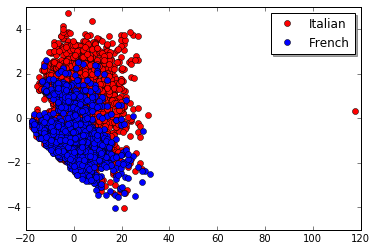

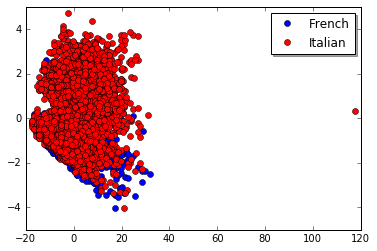

In [17]:
import warnings
warnings.filterwarnings('ignore')

def create_2D_projection(test_data, predictions, group_labels):
    '''Render the 2D projection before trying any fancy GMM modelling'''
    group_train_data = [this_train_data[index] for index, data in enumerate(this_train_labels) if data in group_labels]
    group_train_labels = [this_train_labels[index] for index, data in enumerate(this_train_labels) if data in group_labels]    

    vectorizer = CountVectorizer()
    group_train_docterm = vectorizer.fit_transform(group_train_data)        

    pca = PCA(n_components=2).fit(group_train_docterm.toarray())   
    
    # take any prediction from europe descent and rerun it through our group specific classifier
    group_test_data = [test_data[index] for index, data in enumerate(predictions) if data in group_labels]    
    group_test_docterm = vectorizer.transform(group_test_data)
    
    
    D2_train_data = pca.transform(group_train_docterm.toarray())
    D2_test_data = pca.transform(group_test_docterm.toarray())
    # seperate positive and negative train examples
    french_train = np.array([D2_train_data[i] for i, label in enumerate(group_train_labels) if label == 'french'])
    italian_train = np.array([D2_train_data[i] for i, label in enumerate(group_train_labels) if label == 'italian'])  

    fig, ax = plt.subplots()
    ax.plot(italian_train[:,0], italian_train[:,1], 'ro', label='Italian')
    ax.plot(french_train[:,0], french_train[:,1], 'bo', label='French')
    legend = ax.legend(numpoints=1, loc='upper right', shadow=True)
    
    fig, ax = plt.subplots()
    ax.plot(french_train[:,0], french_train[:,1], 'bo', label='French')    
    ax.plot(italian_train[:,0], italian_train[:,1], 'ro', label='Italian')
    legend = ax.legend(numpoints=1, loc='upper right', shadow=True)
    
            


parse_all_data(add_experimentS1_features)
this_train_data = train_data
this_train_labels = train_labels
this_test_data = test_data
this_test_labels = test_labels


fi_labels = ["french", "italian"]

# train the entire set as normal
lr = LogisticRegression(C=1.0)
vectorizer = CountVectorizer()
train_docterm = vectorizer.fit_transform(this_train_data)
test_docterm = vectorizer.transform(this_test_data)

# predict overall results
lr.fit(train_docterm, this_train_labels)
predictions = lr.predict(test_docterm)
        
# render a scatter plot to see if italian and french are good candidate for guassian mixed models.
create_2D_projection(this_test_data, predictions, fi_labels)   